In [10]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm


entity = 'EF_GR'

data = """

WITH base AS (
    SELECT 
        ROUND(travel_time_distance_km, 0) AS delivery_distance,
        delivery_costs_eur,
        platform_order_code,
        delivery_fee_eur,
        dps_delivery_fee_eur,
        revenue_eur
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders`
    WHERE created_date >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY)), INTERVAL 4 WEEK)
      AND created_date < DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY))
      AND is_own_delivery
      AND is_sent
      AND entity_id = 'FY_CY'
      AND zone_name IS NOT NULL
      AND vendor_price_scheme_type = "Automatic scheme"
      AND delivery_costs_local IS NOT NULL
      AND delivery_fee_local IS NOT NULL
      AND commission_local IS NOT NULL
      AND travel_time_distance_km < 16
),
distinct_distances AS (
    SELECT DISTINCT delivery_distance
    FROM base
),

distance_buckets AS (
    SELECT 
        delivery_distance,
        NTILE(3) OVER (ORDER BY delivery_distance) AS dist_bucket
    FROM distinct_distances
),
quantiles AS (
    SELECT 
        MAX(CASE WHEN dist_bucket = 1 THEN delivery_distance END) AS q1, -- upper bound of shortest third
        MAX(CASE WHEN dist_bucket = 2 THEN delivery_distance END) AS q2  -- upper bound of medium third
    FROM distance_buckets
)

SELECT
    CASE 
        WHEN b.delivery_distance <= q.q1 THEN 'short'
        WHEN b.delivery_distance <= q.q2 THEN 'medium'
        ELSE 'long'
    END AS distance_bucket,
    SUM(b.delivery_costs_eur) / COUNT(DISTINCT b.platform_order_code) AS delivery_cost_per_order,
    SUM(b.delivery_fee_eur) / COUNT(DISTINCT b.platform_order_code) AS delivery_fee_per_order,
    SUM(b.dps_delivery_fee_eur) / COUNT(DISTINCT b.platform_order_code) AS dps_delivery_fee_per_order,
    COUNT(DISTINCT b.platform_order_code) AS total_orders,
    SUM(b.revenue_eur) AS total_revenue,
    sum(b.delivery_costs_eur) AS total_costs,
FROM base b
CROSS JOIN quantiles q
GROUP BY 1
ORDER BY 1;

"""

In [11]:
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

test_df = client.query(data).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [12]:
test_df

,distance_bucket,delivery_cost_per_order,delivery_fee_per_order,dps_delivery_fee_per_order,total_orders,total_revenue,total_costs
0,long,11.040256,4.665162338,4.669610390,1232,1.423022e+04,1.360160e+04
1,medium,6.829420,4.059124044,4.059241704,26942,2.465494e+05,1.839982e+05
2,short,3.653162,1.672520212,1.673128376,404101,2.055647e+06,1.476246e+06


Optimal flat fee: 1.915994003213784
Original total orders: 432275.0 New total orders: 409113.69587852806
Original profit: -882616.2882421805 New profit: -883700.0302638185


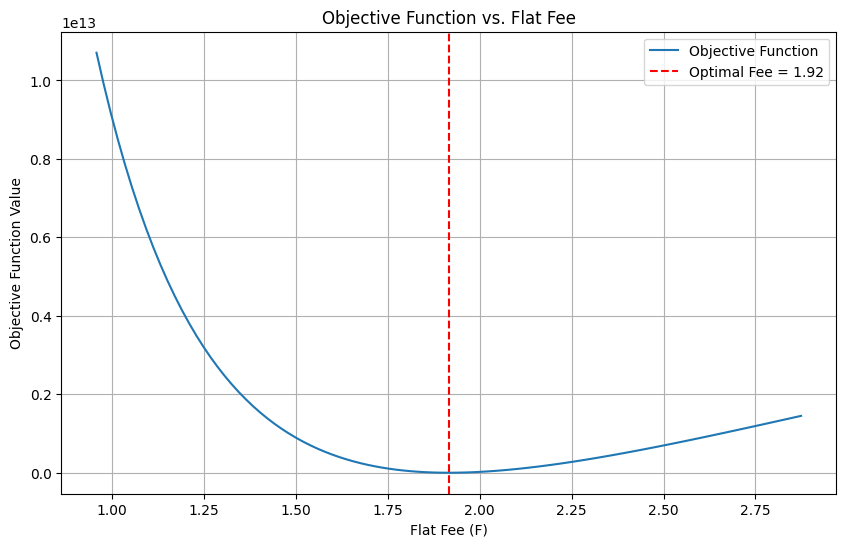

In [13]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

test_df[['delivery_cost_per_order','delivery_fee_per_order','dps_delivery_fee_per_order','total_orders','total_revenue','total_costs']] = test_df[['delivery_cost_per_order','delivery_fee_per_order','dps_delivery_fee_per_order','total_orders','total_revenue','total_costs']].astype(float)

Q_S = test_df[test_df['distance_bucket'] == 'short']['total_orders'].iloc[0]
Q_M = test_df[test_df['distance_bucket'] == 'medium']['total_orders'].iloc[0]
Q_L = test_df[test_df['distance_bucket'] == 'long']['total_orders'].iloc[0]

P_S = test_df[test_df['distance_bucket'] == 'short']['dps_delivery_fee_per_order'].iloc[0]
P_M = test_df[test_df['distance_bucket'] == 'medium']['dps_delivery_fee_per_order'].iloc[0]
P_L = test_df[test_df['distance_bucket'] == 'long']['dps_delivery_fee_per_order'].iloc[0]

C_S = test_df[test_df['distance_bucket'] == 'short']['delivery_cost_per_order'].iloc[0]
C_M = test_df[test_df['distance_bucket'] == 'medium']['delivery_cost_per_order'].iloc[0]
C_L = test_df[test_df['distance_bucket'] == 'long']['delivery_cost_per_order'].iloc[0]

# Elasticities
E_S = -0.9
E_M = -0.8
E_L = -0.7

# Weights
w_Q = 1.0
w_pi = 5.0

# Baseline
Q_orig = Q_S + Q_M + Q_L
profit_orig = (Q_S * (P_S - C_S) +
               Q_M * (P_M - C_M) +
               Q_L * (P_L - C_L))

# Objective function
def objective(F):
    Q_S_new = Q_S * (F / P_S)**E_S
    Q_M_new = Q_M * (F / P_M)**E_M
    Q_L_new = Q_L * (F / P_L)**E_L
    
    Q_new = Q_S_new + Q_M_new + Q_L_new
    profit_new = (Q_S_new * (F - C_S) +
                  Q_M_new * (F - C_M) +
                  Q_L_new * (F - C_L))
    
    orders_diff = (Q_new - Q_orig)**2
    profit_diff = (profit_new - profit_orig)**2
    return w_Q * orders_diff + w_pi * profit_diff

# Initial Guess
F_init = (Q_S * P_S + Q_M * P_M + Q_L * P_L) / Q_orig

# Optimization
result = minimize(objective, F_init, bounds=[(0.01, None)])  # F > 0.01
if result.success:
    F_opt = result.x[0]
    print("Optimal flat fee:", F_opt)
    # Check results
    Q_S_new = Q_S * (F_opt / P_S)**E_S
    Q_M_new = Q_M * (F_opt / P_M)**E_M
    Q_L_new = Q_L * (F_opt / P_L)**E_L
    Q_new = Q_S_new + Q_M_new + Q_L_new
    profit_new = (Q_S_new * (F_opt - C_S) +
                  Q_M_new * (F_opt - C_M) +
                  Q_L_new * (F_opt - C_L))
    
    print("Original total orders:", Q_orig, "New total orders:", Q_new)
    print("Original profit:", profit_orig, "New profit:", profit_new)
else:
    print("Optimization failed:", result.message)

# ---------------------------
# Plot the Objective Function
# ---------------------------
# Let's pick a range around the optimal fee to visualize
F_min = max(0.01, F_opt * 0.5) if result.success else 0.01
F_max = F_opt * 1.5 if result.success else (F_init * 2)
F_values = np.linspace(F_min, F_max, 100)

objective_values = [objective(f) for f in F_values]

plt.figure(figsize=(10, 6))
plt.plot(F_values, objective_values, label='Objective Function')
if result.success:
    plt.axvline(F_opt, color='red', linestyle='--', label=f'Optimal Fee = {F_opt:.2f}')
plt.title('Objective Function vs. Flat Fee')
plt.xlabel('Flat Fee (F)')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()


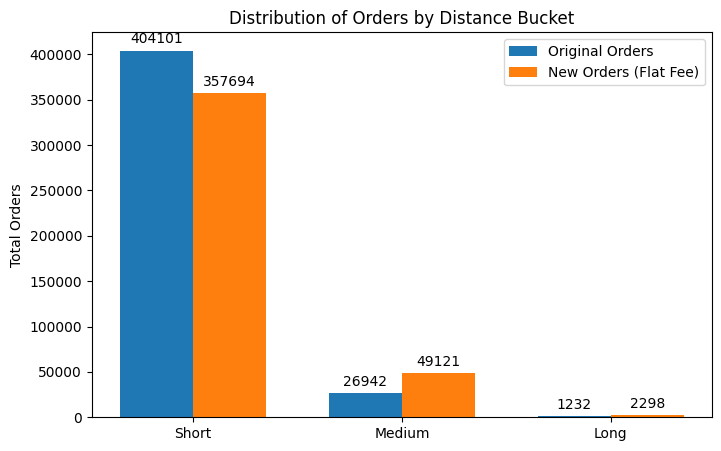

In [14]:
# Calculate new orders for each distance bucket using the optimal flat fee
Q_S_new = Q_S * (F_opt / P_S)**E_S
Q_M_new = Q_M * (F_opt / P_M)**E_M
Q_L_new = Q_L * (F_opt / P_L)**E_L

# Data for plotting
buckets = ['Short', 'Medium', 'Long']
orders_original = [Q_S, Q_M, Q_L]
orders_new = [Q_S_new, Q_M_new, Q_L_new]

# Plotting the results
x = np.arange(len(buckets))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, orders_original, width, label='Original Orders')
rects2 = ax.bar(x + width/2, orders_new, width, label='New Orders (Flat Fee)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Orders')
ax.set_title('Distribution of Orders by Distance Bucket')
ax.set_xticks(x)
ax.set_xticklabels(buckets)
ax.legend()

# Optionally, add a function to label the bars with their heights
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [26]:
import math
from scipy.stats import norm

def calculate_sample_size_unequal(p0, mde, r, alpha=0.05, power=0.8, m_comparisons=1):
    """
    Calculate the required sample sizes for control and treatment groups for a 
    two-sample proportion test with unequal allocation.
    
    Parameters:
    - p0: Baseline conversion rate.
    - mde: Minimum Detectable Effect (absolute change from p0).
    - r: Allocation ratio (n_treatment / n_control).
         For example, if control gets 80% and treatment gets 5%, then r = 0.05/0.80.
    - alpha: Overall significance level.
    - power: Desired power (1 - beta).
    - m_comparisons: Number of treatment comparisons (for Bonferroni correction).
    
    Returns:
    - n_control: Required sample size for the control group.
    - n_treatment: Required sample size for each treatment group.
    """
    # Adjust alpha for multiple comparisons (Bonferroni)
    alpha_adjusted = alpha / m_comparisons
    
    p1 = p0 + mde
    p_avg = (p0 + p1) / 2.0
    
    # z-value for a two-tailed test using the adjusted alpha
    z_alpha = norm.ppf(1 - alpha_adjusted/2)
    z_beta = norm.ppf(power)
    
    # The formula for unequal allocation:
    numerator = (z_alpha * math.sqrt(p_avg * (1 - p_avg) * (1 + 1/r)) +
                 z_beta * math.sqrt(p0 * (1 - p0) + (p1 * (1 - p1)) / r)) ** 2
    denominator = (p1 - p0) ** 2
    
    n_control = math.ceil(numerator / denominator)
    n_treatment = math.ceil(n_control * r)
    
    return n_control, n_treatment

def calculate_duration(n_control, n_treatment, total_daily_visitors, f_control, f_treatment):
    """
    Estimate the duration of the experiment in days for both control and treatment groups.
    
    Parameters:
    - n_control: Required sample size for the control group.
    - n_treatment: Required sample size for each treatment group.
    - total_daily_visitors: Total number of daily visitors.
    - f_control: Fraction of visitors allocated to the control group.
    - f_treatment: Fraction of visitors allocated to each treatment group.
    
    Returns:
    - duration_control: Estimated days required to meet control sample size.
    - duration_treatment: Estimated days required to meet treatment sample size.
    """
    daily_control = total_daily_visitors * f_control
    daily_treatment = total_daily_visitors * f_treatment
    
    duration_control = n_control / daily_control
    duration_treatment = n_treatment / daily_treatment
    return duration_control, duration_treatment

# Example usage:
if __name__ == "__main__":
    # Experiment parameters:
    baseline_conversion = 0.05  # e.g., 10% baseline conversion rate
    mde = baseline_conversion * 0.05                 # e.g., 2% absolute improvement (from 10% to 12%)
    alpha = 0.05                # Overall significance level
    power = 0.8                 # Desired power (80%)
    
    # Allocation fractions: 80% for control, 5% for each treatment.
    # With one control and four treatments, fractions are:
    f_control = 0.5
    f_treatment = 0.5  # for each treatment
    
    # For a single treatment vs. control comparison, the allocation ratio is:
    allocation_ratio = f_treatment / f_control  # 0.05 / 0.80 = 0.0625
    
    # We have 4 treatment comparisons.
    num_comparisons = 1
    
    # Calculate sample sizes using the unequal allocation formula (Bonferroni-adjusted)
    n_control, n_treatment = calculate_sample_size_unequal(
        p0=baseline_conversion, 
        mde=mde, 
        r=allocation_ratio, 
        alpha=alpha, 
        power=power, 
        m_comparisons=num_comparisons
    )
    
    # Assume a total of 20,000 daily visitors.
    total_daily_visitors = 5000
    
    # Calculate experiment durations for control and for each treatment group.
    duration_control, duration_treatment = calculate_duration(
        n_control, 
        n_treatment, 
        total_daily_visitors, 
        f_control=f_control, 
        f_treatment=f_treatment
    )
    
    print("Required sample size for control group:", n_control)
    print("Required sample size for each treatment group:", n_treatment)
    print("Estimated experiment duration for control group (days):", duration_control)
    print("Estimated experiment duration for each treatment group (days):", duration_treatment)


Required sample size for control group: 122124
Required sample size for each treatment group: 122124
Estimated experiment duration for control group (days): 48.8496
Estimated experiment duration for each treatment group (days): 48.8496


In [ ]:
# Save DataFrame to a Parquet file
raw_data.to_parquet("data.parquet", index=False)

In [3]:
listings_data = """

WITH listings_agg AS (
  SELECT
    dh_platform,
    global_entity_id, 
    platform,
    session_key,
    shopId,
    eventTimestamp,
    ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeUpper' THEN ev.value END IGNORE NULLS) AS promised_upper_array,
    ARRAY_AGG(CASE WHEN ev.name = 'promisedDeliveryTimeRangeLower' THEN ev.value END IGNORE NULLS) AS promised_lower_array,
    ARRAY_AGG(CASE WHEN ev.name = 'locationCountry' THEN ev.value END IGNORE NULLS) AS location_country,
    ARRAY_AGG(CASE WHEN ev.name = 'locationCity' THEN ev.value END IGNORE NULLS) AS location_city,
    ARRAY_AGG(CASE WHEN ev.name = 'shopDeliveryFee' THEN ev.value END IGNORE NULLS) AS delivery_fee_array,
    ARRAY_AGG(CASE WHEN ev.name = 'serviceFee' THEN ev.value END IGNORE NULLS) AS service_fee_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopMinimumOrderValue' THEN ev.value END IGNORE NULLS) AS mov_array,
    ARRAY_AGG(CASE WHEN ev.name = 'verticalType' THEN ev.value END IGNORE NULLS) AS verticaltype_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopSponsoring' THEN ev.value END IGNORE NULLS) AS sponsor_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopListType' THEN ev.value END IGNORE NULLS) AS shoplisttype_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopType' THEN ev.value END IGNORE NULLS) AS shoptype_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopName' THEN ev.value END IGNORE NULLS) AS shopname_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopCuisine' THEN ev.value END IGNORE NULLS) AS cuisine_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopRank' THEN ev.value END IGNORE NULLS) AS rank_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopPosition' THEN ev.value END IGNORE NULLS) AS position_array,
    ARRAY_AGG(CASE WHEN ev.name = 'perseusClientIdNew' THEN ev.value END IGNORE NULLS) AS id_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopCategorySelected' THEN ev.value END IGNORE NULLS) AS category_array,
    ARRAY_AGG(CASE WHEN ev.name = 'pageType' THEN ev.value END IGNORE NULLS) AS pageType_array,
    ARRAY_AGG(CASE WHEN ev.name = 'userId' THEN ev.value END IGNORE NULLS) AS user_array,
    ARRAY_AGG(CASE WHEN ev.name = 'eventAction' THEN ev.value END IGNORE NULLS) AS event_array,
    ARRAY_AGG(CASE WHEN ev.name = 'hour-of-the-day' THEN ev.value END IGNORE NULLS) AS hotd_array,
    ARRAY_AGG(CASE WHEN ev.name = 'shopRatingQuality' THEN ev.value END IGNORE NULLS) AS shopRatingQuality_array
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
    UNNEST(pe.eventVariables) AS ev
  WHERE partition_date > '2025-02-02' and partition_date < '2025-02-15'
    AND eventAction = 'shop_impressions.loaded'
    AND pe.global_entity_id = 'EF_GR'
  GROUP BY dh_platform,global_entity_id,platform, session_key, shopId, eventTimestamp
), 
listings_raw as (
SELECT 
  dh_platform,
  global_entity_id,
  platform,
  session_key,
  shopId,
  eventTimestamp,
  promised_value AS promisedDeliveryTimeRangeUpper,
  IF(pos < ARRAY_LENGTH(promised_lower_array), promised_lower_array[OFFSET(pos)], NULL) AS promisedDeliveryTimeRangeLower,
  IF(pos < ARRAY_LENGTH(location_country), location_country[OFFSET(pos)], NULL) AS locationCountry,
  IF(pos < ARRAY_LENGTH(location_city), location_city[OFFSET(pos)], NULL) AS locationCity,
  IF(pos < ARRAY_LENGTH(delivery_fee_array), delivery_fee_array[OFFSET(pos)], NULL) AS shopDeliveryFee,
  IF(pos < ARRAY_LENGTH(service_fee_array), service_fee_array[OFFSET(pos)], NULL) AS serviceFee,
  IF(pos < ARRAY_LENGTH(mov_array), mov_array[OFFSET(pos)], NULL) AS shopMinimumOrderValue,
  IF(pos < ARRAY_LENGTH(verticaltype_array), verticaltype_array[OFFSET(pos)], NULL) AS verticalType,
  IF(pos < ARRAY_LENGTH(shoplisttype_array), shoplisttype_array[OFFSET(pos)], NULL) AS shopListType,
  IF(pos < ARRAY_LENGTH(sponsor_array), sponsor_array[OFFSET(pos)], NULL) AS shopSponsoring,
  IF(pos < ARRAY_LENGTH(shoptype_array), shoptype_array[OFFSET(pos)], NULL) AS shopType,
  IF(pos < ARRAY_LENGTH(shopname_array), shopname_array[OFFSET(pos)], NULL) AS shopName,
  IF(pos < ARRAY_LENGTH(cuisine_array), cuisine_array[OFFSET(pos)], NULL) AS shopCuisine,
  IF(pos < ARRAY_LENGTH(rank_array), rank_array[OFFSET(pos)], NULL) AS shopRank,
  IF(pos < ARRAY_LENGTH(position_array), position_array[OFFSET(pos)], NULL) AS shopPosition,
  IF(pos < ARRAY_LENGTH(id_array), id_array[OFFSET(pos)], NULL) AS perseusClientId,
  IF(pos < ARRAY_LENGTH(category_array), category_array[OFFSET(pos)], NULL) AS shopCategorySelected,
  IF(pos < ARRAY_LENGTH(pageType_array), pageType_array[OFFSET(pos)], NULL) AS pageType,
  IF(pos < ARRAY_LENGTH(user_array), user_array[OFFSET(pos)], NULL) AS userId,
  IF(pos < ARRAY_LENGTH(event_array), event_array[OFFSET(pos)], NULL) AS eventAction,
  IF(pos < ARRAY_LENGTH(hotd_array), hotd_array[OFFSET(pos)], NULL) AS hour_of_the_day,
  IF(pos < ARRAY_LENGTH(shopRatingQuality_array), shopRatingQuality_array[OFFSET(pos)], NULL) AS shopRatingQuality,
  row_number() over (partition by session_key, shopId order by eventTimestamp asc) as rn
FROM listings_agg,
UNNEST(promised_upper_array) AS promised_value WITH OFFSET AS pos
ORDER BY dh_platform, global_entity_id, platform, session_key, shopId,eventTimestamp, pos
), listings_final as (
select *
from listings_raw
where rn = 1
),
details_agg AS (
  SELECT 
    session_key session_key_details,
    shopId shopId_details,
    eventTimestamp timestamp_details,
    row_number() over (partition by session_key, shopId order by eventTimestamp) as rn_details
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe, 
    UNNEST(pe.eventVariables) AS ev
  WHERE partition_date > '2025-02-02' and partition_date < '2025-02-15'
    AND eventAction = 'shop_details.loaded'
    AND pe.global_entity_id = 'EF_GR'
  GROUP BY session_key, shopId, eventTimestamp
),
details_final as (
select *
from details_agg
where rn_details = 1
)
select *
from listings_final lf
left join details_final df on df.session_key_details = lf.session_key and df.shopId_details = lf.shopId

""" 

In [4]:
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

listings_df = client.query(listings_data).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
import pandas as pd
import numpy as np

# Assume listings_df is your DataFrame.

# Convert the relevant columns to numeric, coercing non-numeric values to NaN.
listings_df['promisedDeliveryTimeRangeUpper'] = pd.to_numeric(
    listings_df['promisedDeliveryTimeRangeUpper'], errors='coerce'
)
listings_df['promisedDeliveryTimeRangeLower'] = pd.to_numeric(
    listings_df['promisedDeliveryTimeRangeLower'], errors='coerce'
)
listings_df['shopDeliveryFee'] = pd.to_numeric(
    listings_df['shopDeliveryFee'], errors='coerce'
)

# Optional: Check if conversion worked as expected.
print(listings_df[['promisedDeliveryTimeRangeUpper', 'promisedDeliveryTimeRangeLower', 'shopDeliveryFee']].dtypes)

# Compute the average delivery time.
# (Here I'm taking the midpoint; if you want the sum, remove the division by 2.)
listings_df['average_delivery_time'] = (
    listings_df['promisedDeliveryTimeRangeUpper'] + listings_df['promisedDeliveryTimeRangeLower']
) / 2

epsilon = 1e-6  # small constant to avoid log(0)
listings_df['log_delivery_fee'] = np.log(listings_df['shopDeliveryFee'] + epsilon)
listings_df['log_promised_time'] = np.log(listings_df['average_delivery_time'] + epsilon)

# Add a new column 'click': 1 if session_key_details is not null, else 0
listings_df['click'] = listings_df['session_key_details'].notnull().astype(int)

# Check the resulting DataFrame
print(listings_df[['promisedDeliveryTimeRangeUpper', 
                   'promisedDeliveryTimeRangeLower', 
                   'average_delivery_time', 
                   'log_delivery_fee', 
                   'log_promised_time', 
                   'click']].head())


# # Aggregate the data at the session level
# session_df = listings_df.groupby(['session_key','locationCity']).agg(
#     avg_delivery_fee = ('shopDeliveryFee', 'mean'),
#     avg_delivery_time = ('average_delivery_time', 'mean'),
#     click_rate = ('click', 'mean'),    # proportion of shops clicked per session
#     num_exposures = ('session_key', 'count')  # number of shops viewed in the session
# ).reset_index()

# # For log-transformation, add a small constant to avoid log(0)
# epsilon = 1e-6
# session_df['log_avg_delivery_fee'] = np.log(session_df['avg_delivery_fee'] + epsilon)
# session_df['log_avg_delivery_time'] = np.log(session_df['avg_delivery_time'] + epsilon)

# print(session_df.head())

promisedDeliveryTimeRangeUpper      int64
promisedDeliveryTimeRangeLower      int64
shopDeliveryFee                   float64
dtype: object
   promisedDeliveryTimeRangeUpper  promisedDeliveryTimeRangeLower  \
0                              35                              30   
1                              35                              30   
2                              35                              30   
3                              25                              20   
4                              35                              30   

   average_delivery_time  log_delivery_fee  log_promised_time  click  
0                   32.5        -13.815511           3.481240      0  
1                   32.5        -13.815511           3.481240      0  
2                   32.5         -0.693145           3.481240      0  
3                   22.5        -13.815511           3.113515      0  
4                   32.5        -13.815511           3.481240      0  


In [10]:
import pandas as pd
import statsmodels.api as sm

# Create dummy variables for locationCity, dropping the first category
location_dummies = pd.get_dummies(session_df['locationCity'], prefix='locationCity', drop_first=True)

# Combine numeric predictors with the dummy variables
X = pd.concat([session_df[['log_avg_delivery_fee', 'log_avg_delivery_time']], location_dummies], axis=1)
X = sm.add_constant(X)  # Adds the intercept term

# Define the dependent variable
y = session_df['click_rate']

# Debug: Print data types before conversion
print("Before conversion, X dtypes:")
print(X.dtypes)
print("\nBefore conversion, y dtype:")
print(y.dtype)

# Convert all columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Debug: Check data types again
print("\nAfter pd.to_numeric, X dtypes:")
print(X.dtypes)
print("\nAfter pd.to_numeric, y dtype:")
print(y.dtype)

# Force conversion to float if needed
X = X.astype(float)
y = y.astype(float)

# Optionally, drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Debug: Check shapes and dtypes one more time
print("\nFinal X dtypes:")
print(X.dtypes)
print("\nFinal X shape:", X.shape)
print("Final y shape:", y.shape)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


NameError: name 'session_df' is not defined

In [6]:
import statsmodels.api as sm

# Define the formula: add additional covariates as needed.
formula = "click ~ log_delivery_fee + log_promised_time"

# Fit a GEE model clustering on session_id
gee_model = sm.GEE.from_formula(formula,
                                groups="session_key",
                                data=listings_df,
                                family=sm.families.Binomial())
gee_result = gee_model.fit()

print(gee_result.summary())

                               GEE Regression Results                              
Dep. Variable:                       click   No. Observations:             25393601
Model:                                 GEE   No. clusters:                   853713
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                 130
Family:                           Binomial   Mean cluster size:                29.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sun, 09 Mar 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         02:22:30
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.0399      0.018   -221.432      0.000      -4.07

In [9]:
# Create design matrices for fixed effects using patsy.
formula = "click ~ log_delivery_fee + log_promised_time"
y, X = patsy.dmatrices(formula, data, return_type='dataframe')

# Create a variance components design matrix for the random intercept by session.
vc_formula = "0 + C(session_key)"
vc_matrix = patsy.dmatrix(vc_formula, data, return_type='dataframe')
vc = {"session": vc_matrix}

# Fit the BinomialBayesMixedGLM model using variational Bayes
model = BinomialBayesMixedGLM(endog=y, exog=X, exog_vc=vc)
fit_result = model.fit_vb()

print(fit_result.summary())

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/patsy/compat.py", line 36, in call_and_wrap_exc
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/patsy/eval.py", line 169, in eval
    return eval(code, {}, VarLookupDict([inner_namespace]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
  File "/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/patsy/eval.py", line 52, in __getitem__
    return d[key]
           ~^^^^^
  File "/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/patsy/eval.py", line 52, in __getitem__
    return d[key]
           ~^^^^^
TypeError: string indices must be integers, not 'str'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/shazeb.asad/global_pricing/.venv/